<a href="https://colab.research.google.com/github/Adrianus-Bagas/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection_(Training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteksi Tumor Otak

## 1. Import beberapa libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import imutils
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import VGG16, ResNet50V2, InceptionV3, EfficientNetB7, Xception
import joblib

## 2. Memuat data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    return X, y, labels

In [ ]:
X, Y, label = load_data('/content/drive/MyDrive/dataset/tumor/')

100%|██████████| 2/2 [00:01<00:00,  1.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

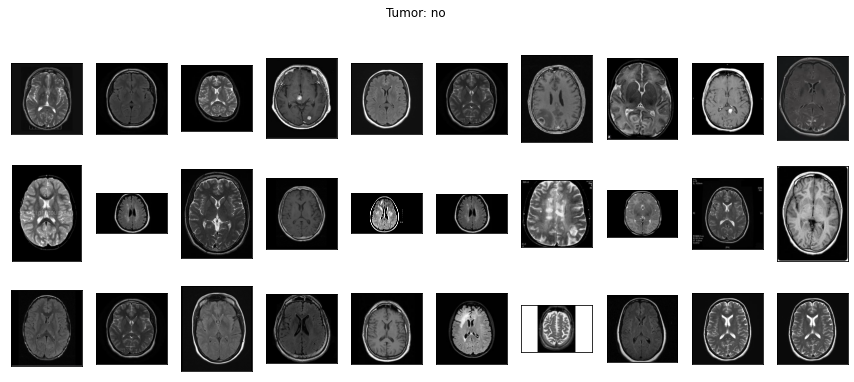

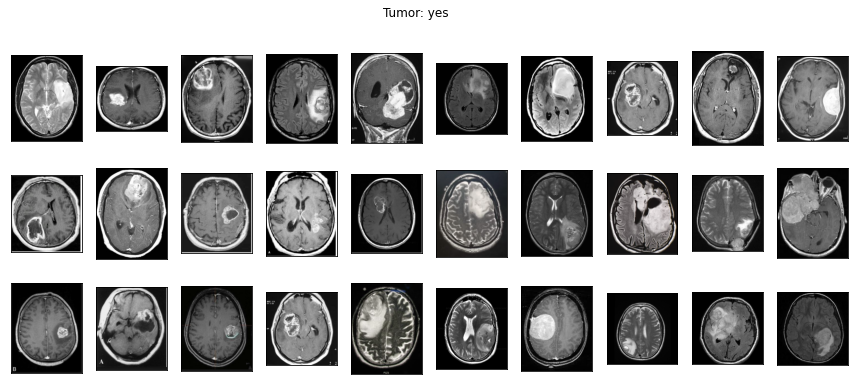

In [ ]:
plot_samples(X, Y, label, 30)

## 3. Image Preprocessing

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
X_new = crop_imgs(set_name=X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


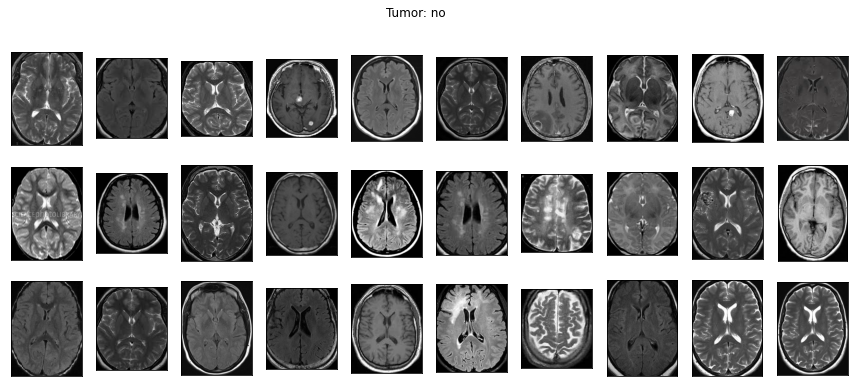

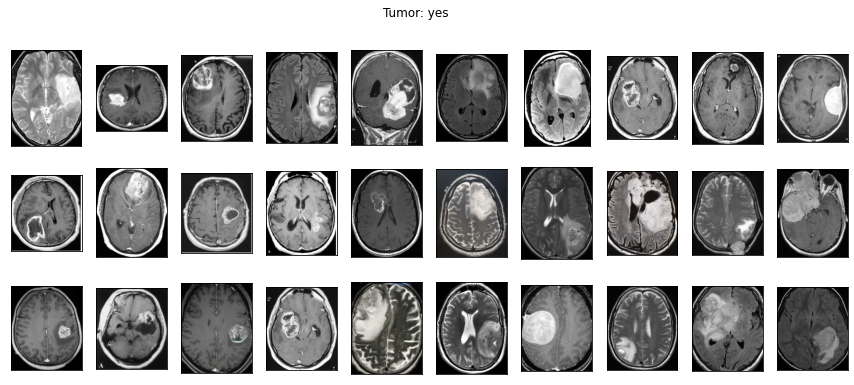

In [ ]:
plot_samples(X_new, Y, label, 30)

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_prep = preprocess_imgs(set_name=X_new, img_size=(100,100))

In [ ]:
X_prep = X_prep/255

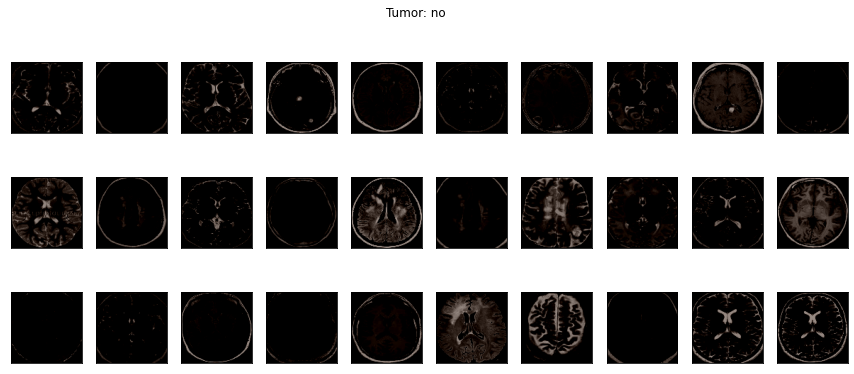

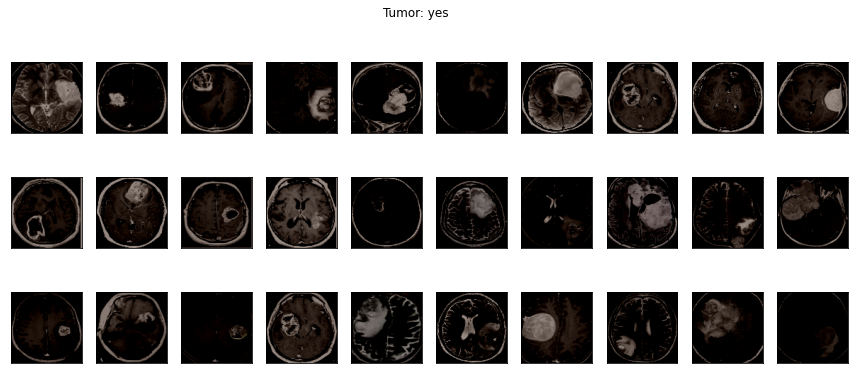

In [ ]:
plot_samples(X_prep, Y, label, 30)

In [ ]:
X_prep.shape

(196, 100, 100, 3)

# 4. Model InceptionV3, VGG19, ResNet50V2, EfficientNetB7, dan Xception

In [ ]:
inception = InceptionV3(include_top=False,weights='imagenet',input_shape=(100,100,3))
model_inception=Sequential()
model_inception.add(inception)
model_inception.add(Flatten())
model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
vgg = VGG16(include_top=False,weights='imagenet',input_shape=(100,100,3))
model_vgg=Sequential()
model_vgg.add(vgg)
model_vgg.add(MaxPooling2D(pool_size=(2,2)))
model_vgg.add(Flatten())
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 512)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [ ]:
resnet = ResNet50V2(include_top=False,weights='imagenet',input_shape=(100,100,3))
model_resnet=Sequential()
model_resnet.add(resnet)
model_resnet.add(MaxPooling2D(pool_size=(2,2)))
model_resnet.add(MaxPooling2D(pool_size=(2,2)))
model_resnet.add(Flatten())
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 2048)       0         
 2D)                                                             
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
enet = EfficientNetB7(include_top=False,weights='imagenet',input_shape=(100,100,3))
model_enet=Sequential()
model_enet.add(enet)
model_enet.add(MaxPooling2D(pool_size=(2,2)))
model_enet.add(MaxPooling2D(pool_size=(2,2)))
model_enet.add(Flatten())
model_enet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 4, 4, 2560)       64097687  
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 2, 2, 2560)       0         
 g2D)                                                            
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 2560)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2560)              0         
                                                                 
Total params: 64,097,687
Trainable params: 63,786,960
Non-trainable params: 310,727
_________________________________________________________________


In [ ]:
xnet = Xception(include_top=False,weights='imagenet',input_shape=(100,100,3))
model_xnet=Sequential()
model_xnet.add(xnet)
model_xnet.add(MaxPooling2D(pool_size=(2,2)))
model_xnet.add(Flatten())
model_xnet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 1, 1, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


# 5. Prediksi Menggunakan Random Forest

## a. Ekstraksi Fitur InceptionV3

In [ ]:
model_feat_inception = Model(inputs=model_inception.input,outputs=model_inception.get_layer('flatten').output)

In [ ]:
X_feat_inception = model_feat_inception.predict(X_prep)
print(X_feat_inception.shape)

(196, 2048)


In [ ]:
# Split the train and validation sets 
X_train_inception, X_test_inception, Y_train, Y_test = train_test_split(X_feat_inception, Y, test_size=0.2, random_state=42)

In [ ]:
clf_inception = RandomForestClassifier(n_estimators=200, random_state=500)
clf_inception.fit(X_train_inception,Y_train.ravel())

RandomForestClassifier(n_estimators=200, random_state=500)

In [ ]:
accuracy_inception = round(accuracy_score(Y_test,clf_inception.predict(X_test_inception))*100,4)
precision_inception = round(precision_score(Y_test,clf_inception.predict(X_test_inception))*100,4)
recall_inception = round(recall_score(Y_test,clf_inception.predict(X_test_inception))*100,4)
f1_inception = round(f1_score(Y_test,clf_inception.predict(X_test_inception))*100,4)
print("Accuracy :",accuracy_inception)
print("Precision :",precision_inception)
print("Recall :",recall_inception)
print("F1 Score :",f1_inception)

Accuracy : 80.0
Precision : 78.9474
Recall : 78.9474
F1 Score : 78.9474


In [ ]:
def print_conf(y_test, result, classes, title='Confusion matrix'):
  conf_matrix = confusion_matrix(y_test, result)
  plt.figure(figsize=(6,6))
  sns.heatmap(conf_matrix, 
              annot=True,
              xticklabels=classes, 
              yticklabels=classes,
              cmap="Blues",
              fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(title)
  plt.show()

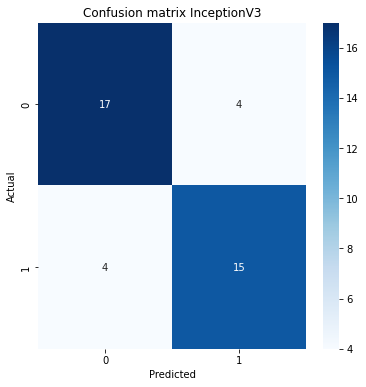

In [ ]:
print_conf(Y_test, clf_inception.predict(X_test_inception), [0, 1], title="Confusion matrix InceptionV3")

## b. Ekstraksi Fitur VGG16

In [ ]:
model_feat_vgg = Model(inputs=model_vgg.input,outputs=model_vgg.get_layer('flatten_1').output)

In [ ]:
X_feat_vgg = model_feat_vgg.predict(X_prep)
print(X_feat_vgg.shape)

(196, 512)


In [ ]:
# Split the train and validation sets 
X_train_vgg, X_test_vgg, Y_train, Y_test = train_test_split(X_feat_vgg, Y, test_size=0.2, random_state=42)

In [ ]:
clf_vgg = RandomForestClassifier(n_estimators=200, random_state=500)
clf_vgg.fit(X_train_vgg,Y_train.ravel())

RandomForestClassifier(n_estimators=200, random_state=500)

In [ ]:
accuracy_vgg = round(accuracy_score(Y_test,clf_vgg.predict(X_test_vgg))*100,4)
precision_vgg = round(precision_score(Y_test,clf_vgg.predict(X_test_vgg))*100,4)
recall_vgg = round(recall_score(Y_test,clf_vgg.predict(X_test_vgg))*100,4)
f1_vgg = round(f1_score(Y_test,clf_vgg.predict(X_test_vgg))*100,4)
print("Accuracy :",accuracy_vgg)
print("Precision :",precision_vgg)
print("Recall :",recall_vgg)
print("F1 Score :",f1_vgg)

Accuracy : 82.5
Precision : 83.3333
Recall : 78.9474
F1 Score : 81.0811


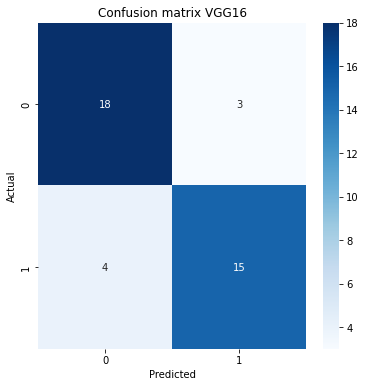

In [ ]:
print_conf(Y_test, clf_vgg.predict(X_test_vgg), [0, 1], title="Confusion matrix VGG16")

## c. Ekstraksi Fitur ResNet50V2

In [ ]:
model_feat_resnet = Model(inputs=model_resnet.input,outputs=model_resnet.get_layer('flatten_2').output)

In [ ]:
X_feat_resnet = model_feat_resnet.predict(X_prep)
print(X_feat_resnet.shape)

(196, 2048)


In [ ]:
# Split the train and validation sets 
X_train_resnet, X_test_resnet, Y_train, Y_test = train_test_split(X_feat_resnet, Y, test_size=0.2, random_state=42)

In [ ]:
clf_resnet = RandomForestClassifier(n_estimators=200, random_state=500)
clf_resnet.fit(X_train_resnet,Y_train.ravel())

RandomForestClassifier(n_estimators=200, random_state=500)

In [ ]:
accuracy_resnet = round(accuracy_score(Y_test,clf_resnet.predict(X_test_resnet))*100,4)
precision_resnet = round(precision_score(Y_test,clf_resnet.predict(X_test_resnet))*100,4)
recall_resnet = round(recall_score(Y_test,clf_resnet.predict(X_test_resnet))*100,4)
f1_resnet = round(f1_score(Y_test,clf_resnet.predict(X_test_resnet))*100,4)
print("Accuracy :",accuracy_resnet)
print("Precision :",precision_resnet)
print("Recall :",recall_resnet)
print("F1 Score :",f1_resnet)

Accuracy : 90.0
Precision : 94.1176
Recall : 84.2105
F1 Score : 88.8889


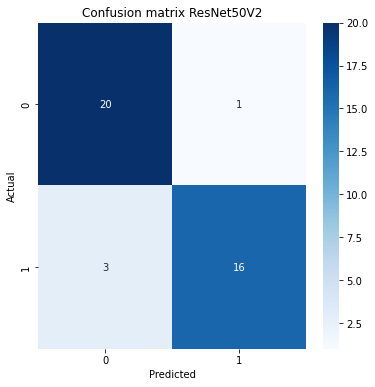

In [ ]:
print_conf(Y_test, clf_resnet.predict(X_test_resnet), [0, 1], title="Confusion matrix ResNet50V2")

## d. Ekstraksi Fitur EfficientNetB7

In [ ]:
model_feat_enet = Model(inputs=model_enet.input,outputs=model_enet.get_layer('flatten_3').output)

In [ ]:
X_feat_enet = model_feat_enet.predict(X_prep)
print(X_feat_enet.shape)

(196, 2560)


In [ ]:
# Split the train and validation sets 
X_train_enet, X_test_enet, Y_train, Y_test = train_test_split(X_feat_enet, Y, test_size=0.2, random_state=42)

In [ ]:
clf_enet = RandomForestClassifier(n_estimators=200, random_state=500)
clf_enet.fit(X_train_enet,Y_train.ravel())

RandomForestClassifier(n_estimators=200, random_state=500)

In [ ]:
accuracy_enet = round(accuracy_score(Y_test,clf_enet.predict(X_test_enet))*100,4)
precision_enet = round(precision_score(Y_test,clf_enet.predict(X_test_enet))*100,4)
recall_enet = round(recall_score(Y_test,clf_enet.predict(X_test_enet))*100,4)
f1_enet = round(f1_score(Y_test,clf_enet.predict(X_test_enet))*100,4)
print("Accuracy :",accuracy_enet)
print("Precision :",precision_enet)
print("Recall :",recall_enet)
print("F1 Score :",f1_enet)

Accuracy : 72.5
Precision : 70.0
Recall : 73.6842
F1 Score : 71.7949


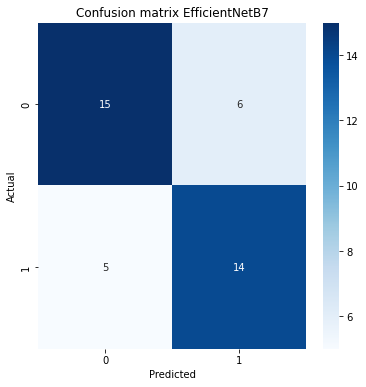

In [ ]:
print_conf(Y_test, clf_enet.predict(X_test_enet), [0, 1], title="Confusion matrix EfficientNetB7")

## e. Ekstraksi Fitur Xception

In [ ]:
model_feat_xnet = Model(inputs=model_xnet.input,outputs=model_xnet.get_layer('flatten_4').output)

In [ ]:
X_feat_xnet = model_feat_xnet.predict(X_prep)
print(X_feat_xnet.shape)

(196, 2048)


In [ ]:
# Split the train and validation sets 
X_train_xnet, X_test_xnet, Y_train, Y_test = train_test_split(X_feat_xnet, Y, test_size=0.2, random_state=42)

In [ ]:
clf_xnet = RandomForestClassifier(n_estimators=200, random_state=500)
clf_xnet.fit(X_train_xnet,Y_train.ravel())

RandomForestClassifier(n_estimators=200, random_state=500)

In [ ]:
accuracy_xnet = round(accuracy_score(Y_test,clf_xnet.predict(X_test_xnet))*100,4)
precision_xnet = round(precision_score(Y_test,clf_xnet.predict(X_test_xnet))*100,4)
recall_xnet = round(recall_score(Y_test,clf_xnet.predict(X_test_xnet))*100,4)
f1_xnet = round(f1_score(Y_test,clf_xnet.predict(X_test_xnet))*100,4)
print("Accuracy :",accuracy_xnet)
print("Precision :",precision_xnet)
print("Recall :",recall_xnet)
print("F1 Score :",f1_xnet)

Accuracy : 82.5
Precision : 83.3333
Recall : 78.9474
F1 Score : 81.0811


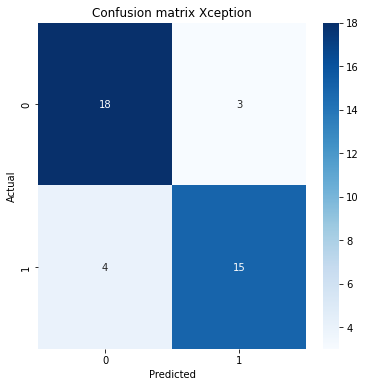

In [ ]:
print_conf(Y_test, clf_xnet.predict(X_test_xnet), [0, 1], title="Confusion matrix Xception")

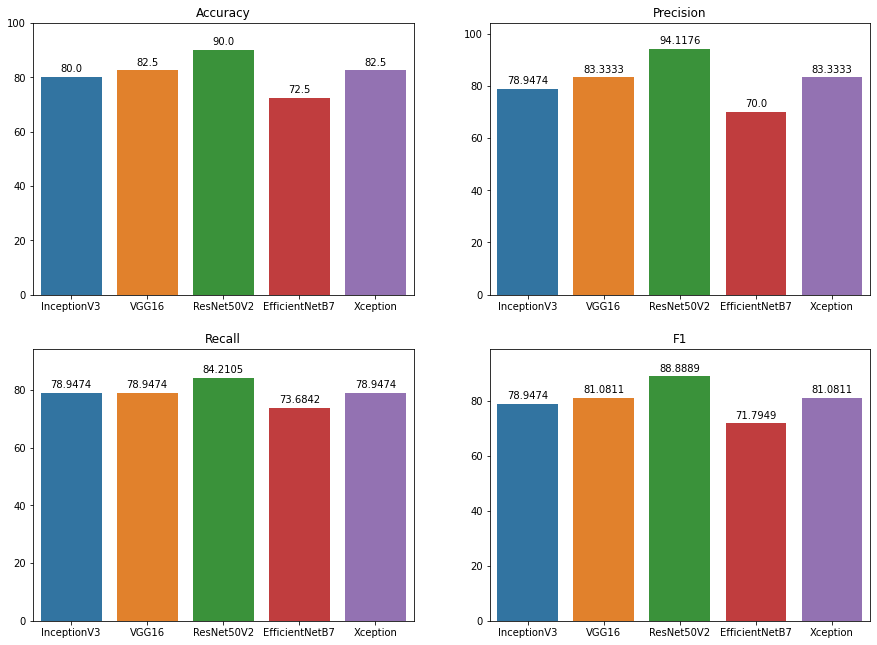

In [ ]:
model_name = ["InceptionV3", "VGG16", "ResNet50V2", "EfficientNetB7", "Xception"]
acc_pred = [accuracy_inception, accuracy_vgg, accuracy_resnet, accuracy_enet, accuracy_xnet]
precision_pred = [precision_inception, precision_vgg, precision_resnet, precision_enet, precision_xnet]
recall_pred = [recall_inception, recall_vgg, recall_resnet, recall_enet, recall_xnet]
f1_pred = [f1_inception, f1_vgg, f1_resnet, f1_enet, f1_xnet]
fig, ax = plt.subplots(2,2, figsize=(15,11))

# ------------------- Accuracy ------------------------

axes = sns.barplot(x=model_name, y=acc_pred, ax=ax[0,0])
for i in range(len(model_name)):
  axes.text(i, acc_pred[i]+3, acc_pred[i], 
           horizontalalignment='center', verticalalignment='center')
axes.set_ylim([0,max(acc_pred)+10])
axes.set_title("Accuracy")

# ------------------- Precission ------------------------

axes = sns.barplot(x=model_name, y=precision_pred, ax=ax[0,1])
for i in range(len(model_name)):
  axes.text(i, precision_pred[i]+3, precision_pred[i], 
           horizontalalignment='center', verticalalignment='center')
axes.set_ylim([0,max(precision_pred)+10])
axes.set_title("Precision")

# ------------------- Recall ------------------------

axes = sns.barplot(x=model_name, y=recall_pred, ax=ax[1,0])
for i in range(len(model_name)):
  axes.text(i, recall_pred[i]+3, recall_pred[i], 
           horizontalalignment='center', verticalalignment='center')
axes.set_ylim([0,max(recall_pred)+10])
axes.set_title("Recall")

# ---------------------- F1 --------------------------

axes = sns.barplot(x=model_name, y=f1_pred, ax=ax[1,1])
for i in range(len(model_name)):
  axes.text(i, f1_pred[i]+3, f1_pred[i], 
           horizontalalignment='center', verticalalignment='center')
axes.set_ylim([0,max(f1_pred)+10])
axes.set_title("F1")

plt.show()

In [ ]:
model_resnet.save('/content/drive/MyDrive/model/model resnet.h5')
joblib.dump(clf_resnet,'/content/drive/MyDrive/model/resnet rf.joblib')

['/content/drive/MyDrive/model/resnet rf.joblib']